### 1. Load data

In [1]:
library(jsonlite)
library(metafor)
library(ggplot2)
library(dplyr)

Loading required package: Matrix



Loading required package: metadat

Loading required package: numDeriv

Loading required package: numDeriv


Loading the 'metafor' package (version 4.4-0). For an
introduction to the package please type: help(metafor)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
df <- fromJSON("/mnt/d/PYDataScience/HIV_TXP_SR/data/supp.json")
# Use the dim function to get the shape of the DataFrame
shape <- dim(df)

# Printing the shape
print(paste("Number of rows:", shape[1]))
print(paste("Number of columns:", shape[2]))

# Use the colnames or names function to get the column names
column_names <- colnames(df)
# Print the column names
print(column_names)


[1] "Number of rows: 48"
[1] "Number of columns: 112"
  [1] "study_id"                                                  
  [2] "author"                                                    
  [3] "year_of_publication"                                       
  [4] "country_of_study"                                          
  [5] "study_type"                                                
  [6] "sample_size_(hiv_seropositive_only)"                       
  [7] "intervention"                                              
  [8] "outcome"                                                   
  [9] "conclusion"                                                
 [10] "hiv_negative_samples"                                      
 [11] "intervention.1"                                            
 [12] "outcome.1"                                                 
 [13] "conclusion.1"                                              
 [14] "remarks"                                                   
 [15] "i

### 2. Publication bias with funnel plot, Egger's test and Begg's Rank correlation test

Loading required package: meta

Loading 'meta' package (version 6.5-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs

Warning message:
“12 studies with NAs omitted from test.”



Regression Test for Funnel Plot Asymmetry

Model:     weighted regression with multiplicative dispersion
Predictor: standard error

Test for Funnel Plot Asymmetry: t = -3.8176, df = 34, p = 0.0005
Limit Estimate (as sei -> 0):   b =  3.9210 (CI: 3.3526, 4.4894)



Warning message:
“12 studies with NAs omitted from test.”
Warning message in cor.test.default(yi.star, vi, method = "kendall", exact = exact):
“Cannot compute exact p-value with ties”



Rank Correlation Test for Funnel Plot Asymmetry

Kendall's tau = 0.1860, p = 0.1109



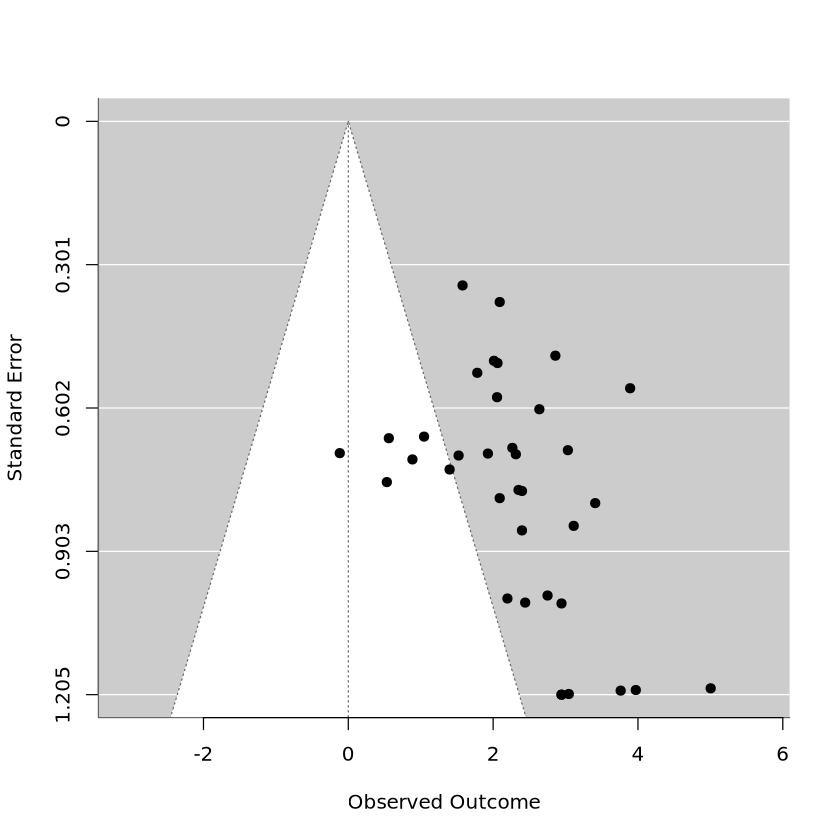

In [3]:
# Creating a copy of the relevant columns
survival_data <- df[, c("1-year_patient_survival_(%)_hiv+", "3-year_patient_survival_(%)_hiv+", ">=_5-year_patient_survival_(%)_hiv+")]

# Replacing "None" with NA and ensuring the data is numeric
survival_data[survival_data == "None"] <- NA
# survival_data <- data.frame(lapply(survival_data, as.numeric))

# Initialize an empty vector for effect sizes
effect_size <- numeric(length(survival_data))

# Loop through each row to apply your selection criteria
for (i in 1:nrow(survival_data)) {
  if (!is.na(survival_data$`>=_5-year_patient_survival_(%)_hiv+`[i])) {
    effect_size[i] <- survival_data$`>=_5-year_patient_survival_(%)_hiv+`[i]
  } else if (!is.na(survival_data$`3-year_patient_survival_(%)_hiv+`[i])) {
    effect_size[i] <- survival_data$`3-year_patient_survival_(%)_hiv+`[i]
  } else if (!is.na(survival_data$`1-year_patient_survival_(%)_hiv+`[i])) {
    effect_size[i] <- survival_data$`1-year_patient_survival_(%)_hiv+`[i]
  } else {
    effect_size[i] <- NA  # For missing data
  }
}

if (!require(meta)) install.packages("meta")
library(meta)

effect_size <- effect_size / 100
sample_size <- df$'sample_size_(hiv_seropositive_only)'
# Adjust effect sizes slightly to avoid 0% and 100%
effect_size <- pmin(pmax(effect_size, 1 / (2 * sample_size)), 1 - 1 / (2 * sample_size))

# Apply logit transformation
logit_effect_size <- log(effect_size / (1 - effect_size))

# Calculate standard error after logit transformation
se_logit <- sqrt(1 / (sample_size * effect_size) + 1 / (sample_size * (1 - effect_size)))
funnel(logit_effect_size, se_logit)

# Make sure you have the 'metafor' package installed
if (!require(metafor)) install.packages("metafor")
library(metafor)

# Convert standard errors to variances for Begg's test
var_logit <- se_logit^2

# Perform Egger's Regression Test
egger_test <- regtest(logit_effect_size, 1/var_logit, model = "lm")
print(egger_test)

# Perform Begg's Rank Correlation Test
begg_test <- ranktest(logit_effect_size, var_logit)
print(begg_test)


### 3. Meta-analysis for patient survival of kidney transplantation in people living with HIV

In [4]:
# Load data from JSON
df <- fromJSON("/mnt/d/PYDataScience/HIV_TXP_SR/data/supp.json")

# Select and rename columns
pt_survival_df <- df[c('sample_size_(hiv_seropositive_only)', 'study_id', 
                       '1-year_patient_survival_(%)_hiv+', 
                       '3-year_patient_survival_(%)_hiv+', 
                       '>=_5-year_patient_survival_(%)_hiv+')]
names(pt_survival_df) <- c('sample_size', 'study_id', '1_yr', '3_yr', '5_yr')

library(metafor)
library(ggplot2)
library(dplyr)

# Function to convert logit to proportion
logit_to_proportion <- function(logit) {
  exp(logit) / (1 + exp(logit))
}

# Function to perform meta-analysis and plot with ggplot2
perform_meta_analysis_and_plot <- function(column_data, sample_size, study_id, title) {
  # Drop NA and convert percentages to proportions
  valid_indices <- which(!is.na(column_data))
  proportions <- column_data[valid_indices] / 100
  sample_sizes <- sample_size[valid_indices]
  valid_study_ids <- study_id[valid_indices]

  # Avoid proportions of 0 and 1 by adding a small constant
  epsilon <- 0.5 / min(sample_sizes)
  proportions <- pmax(epsilon, pmin(1 - epsilon, proportions))

  # Logit Transformation
  logit_effect_size <- log(proportions / (1 - proportions))
    
  # Calculate variances for the logit-transformed effect sizes
  var_logit <- 1 / (sample_sizes * proportions) + 1 / (sample_sizes * (1 - proportions))
    
  # Meta-analysis using the DerSimonian and Laird random effects model
  meta_analysis_result <- rma(yi = logit_effect_size, vi = var_logit, method = "DL")

  # Calculate the standard errors for each study
  se_logit <- sqrt(var_logit)
  # Calculate the z-value for the desired confidence level (e.g., 95% CI)
  z_value <- qnorm(0.975)  # For a 95% CI

  # Calculate the confidence intervals on the logit scale
  ci_lb_logit <- logit_effect_size - z_value * se_logit
  ci_ub_logit <- logit_effect_size + z_value * se_logit

  # Back-transform the confidence intervals from logit to proportion
  ci_lb_proportion <- logit_to_proportion(ci_lb_logit)
  ci_ub_proportion <- logit_to_proportion(ci_ub_logit)
  effect_size_proportion <- logit_to_proportion(meta_analysis_result$yi)
  # Combine the results into a data frame
  study_results <- data.frame(
    study_id = valid_study_ids,
    sample_size = sample_sizes,
    effect_size = effect_size_proportion,
    ci_lb = ci_lb_proportion,
    ci_ub = ci_ub_proportion
  )
  study_results$weight <- weights(meta_analysis_result)
  study_results$weight <- (study_results$weight / sum(study_results$weight)) * 100
  study_results$weight_percent <- sprintf("%.2f%%", study_results$weight)

  # Retrieve the pooled estimate from the meta-analysis result
  pooled_logit_effect_size <- meta_analysis_result$b

  # Retrieve the confidence interval for the pooled estimate
  pooled_ci_lb_logit <- meta_analysis_result$ci.lb
  pooled_ci_ub_logit <- meta_analysis_result$ci.ub

  # Back-transform the pooled estimate and confidence interval from logit to proportion
  pooled_effect_size_proportion <- logit_to_proportion(pooled_logit_effect_size)
  pooled_ci_lb_proportion <- logit_to_proportion(pooled_ci_lb_logit)
  pooled_ci_ub_proportion <- logit_to_proportion(pooled_ci_ub_logit)

  # Now create a separate data frame just for the pooled estimate
  pooled_results <- data.frame(
    study_id = "Pooled Estimate",
    sample_size = sum(study_results$sample_size),
    effect_size = pooled_effect_size_proportion,
    ci_lb = pooled_ci_lb_proportion,
    ci_ub = pooled_ci_ub_proportion,
    weight = sum(study_results$weight)
  )
  pooled_results$weight_percent <- sprintf("%.2f%%", sum(study_results$weight))
  # Combine the individual study results with the pooled estimate
  all_results <- rbind(study_results, pooled_results)
  # Convert the 'study_id' to a factor and specify the level order to ensure
  # the pooled estimate is at the end (the bottom when plotted)
  all_results$study_id <- factor(all_results$study_id, levels = c(as.character(study_results$study_id), "Pooled Estimate"))
  # Add a column for the formatted CI string
  all_results$ci_text <- paste0("[", round(all_results$ci_lb, 2), ", ", round(all_results$ci_ub, 2), "]")

  # Add I2 and p-value from meta_analysis_result to the plot as annotations
  I2 <- meta_analysis_result$I2
  tau2 <- meta_analysis_result$tau2
  p_value <- meta_analysis_result$QEp

  library(ggplot2)

  forest_plot <- ggplot(all_results, aes(y = study_id, x = effect_size, xmin = ci_lb, xmax = ci_ub)) +
    geom_point(data = all_results %>% filter(study_id != "Pooled Estimate"), size = 2) +
    geom_errorbarh(data = all_results %>% filter(study_id != "Pooled Estimate"), height = 0.2) +
    geom_text(aes(label = weight_percent, x = 1.01), hjust = 0, size = 3) +
    geom_text(aes(label = sprintf("%.2f", effect_size), x = 1.05), hjust = 0, size = 3) +
    geom_text(aes(label = ci_text, x = 1.08), hjust = 0, size = 3) +
    # Add annotation labels at the top of the plot
    annotate("text", x = 1.01, y = length(all_results$study_id) + 0.5, label = "Weight", hjust = 0, vjust = 0.5, size = 3.5, fontface = "bold") +
    annotate("text", x = 1.05, y = length(all_results$study_id) + 0.5, label = "Effect", hjust = 0, size = 3.5, fontface = "bold") +
    annotate("text", x = 1.08, y = length(all_results$study_id) + 0.5, label = "95% CI", hjust = 0, size = 3.5, fontface = "bold") +
    # Add tau2, I2 and p-value at the bottom right of the plot
    annotate("text", x = 0.1, y = 3, label = paste0("I² = ", sprintf("%.2f%%", I2)), hjust = 1, size = 3.5, fontface = "bold") +
    annotate("text", x = 0.1, y = 2, label = paste0("tau² = ", sprintf("%.2f%%", tau2)), hjust = 1, size = 3.5, fontface = "bold") +
    annotate("text", x = 0.1, y = 1, label = paste0("p-value = ", sprintf("%.2g", p_value)), hjust = 1, size = 3.5, fontface = "bold") +
    geom_point(data = all_results %>% filter(study_id == "Pooled Estimate"), size = 10, shape = 5, color = "blue") +
    geom_vline(xintercept = pooled_effect_size_proportion, linetype = "dotted", color = "blue") +
    scale_y_discrete(limits = rev(levels(all_results$study_id))) +  # Order y axis based on factor levels
    # Adjust the x-axis breaks to only show 0-1 scale
    scale_x_continuous(breaks = seq(0, 1, by = 0.1), limits = c(0, max(study_results$ci_ub) + 0.2)) +
    theme(
      axis.text.y = element_text(size = rel(0.8)),
      axis.title = element_text(size = rel(1.25)),
      plot.title = element_text(hjust = 0.5),  # Center the title
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.ticks.y = element_blank(),
      axis.ticks.x = element_line(color = "black"),
      plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm")
    ) +
    ggtitle(title) +
    labs(x = "Effect Size (Proportion)", y = "Study") +
    theme(axis.text.y = element_text(size = rel(0.8)),
          axis.title = element_text(size = rel(1.25)))
  # Print the plot
  print(forest_plot)
  # Return the meta-analysis result and the plot
  ggsave('plot.png', forest_plot, width = 1920 / 96, height = 1350 / 96, units = "in")
  return(list(meta_analysis_result = meta_analysis_result, plot = forest_plot, plot_data = all_results))
}


               study_id sample_size effect_size     ci_lb     ci_ub      weight
1            Alfano2018          19   0.9440000 0.7045633 0.9916774   0.9115535
2              Azar2017          13   0.9500000 0.6106983 0.9956734   0.5604095
3           Camargo2019          22   0.9500000 0.7363610 0.9923224   0.9483853
4          Camargo2019a          13   0.9200000 0.6079313 0.9884113   0.8683398
5            Durand2021          75   0.9500000 0.8705719 0.9817084   3.2331318
6           Gathogo2014          35   0.9130000 0.7641084 0.9714274   2.5230543
7           Gathogo2016          78   0.9500000 0.8728271 0.9813428   3.3624570
8           Gathogo2017          51   0.9500000 0.8435888 0.9852797   2.1985296
9             Locke2009         100   0.9500000 0.8854562 0.9790354   4.3108423
10            Locke2014         516   0.9500000 0.9274759 0.9657868  22.2439464
11            Locke2015         499   0.9456000 0.9219113 0.9623957  23.2956825
12            Malat2018         120   0.

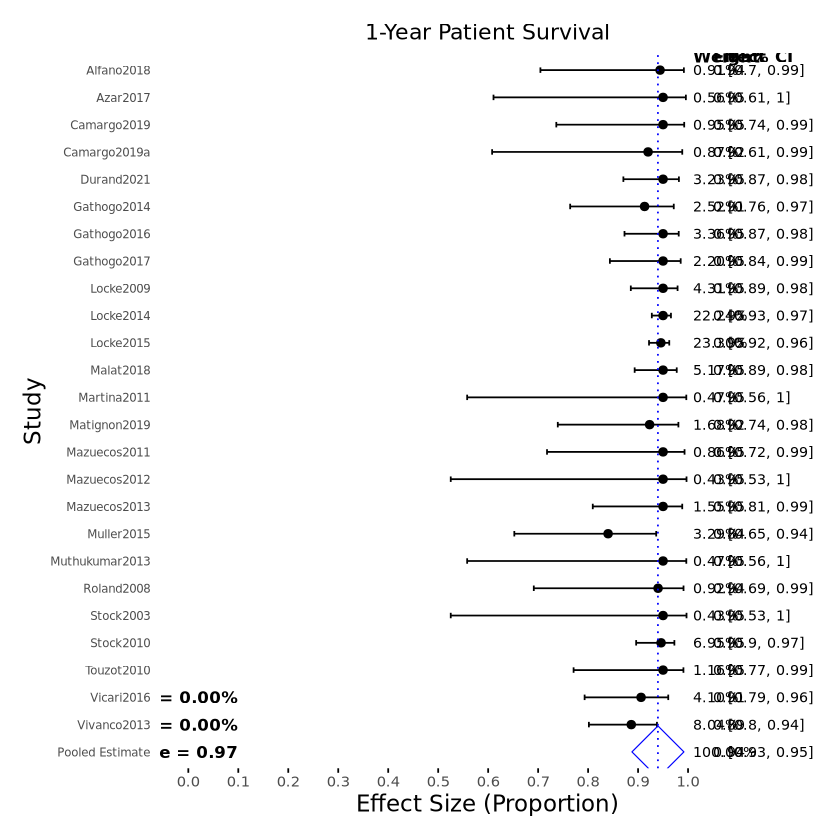

In [5]:

# Inspect the returned 'plot_data' for uniform CI bounds
results <- perform_meta_analysis_and_plot(
  pt_survival_df$'1_yr', 
  pt_survival_df$sample_size, 
  pt_survival_df$study_id, 
  "1-Year Patient Survival"
)
print(results$plot_data)

               study_id sample_size effect_size     ci_lb     ci_ub      weight
1            Abbott2004          47   0.9500000 0.8365371 0.9860220   2.5154528
2            Alfano2018          19   0.9440000 0.7045633 0.9916774   1.2161478
3              Azar2017          13   0.6300000 0.3557870 0.8399869   3.2670259
4             Boyle2017         104   0.8558000 0.7744726 0.9111640   9.0419154
5           Delaney1992          17   0.8824000 0.6317411 0.9704312   2.0417433
6           Gathogo2014          35   0.9130000 0.7641084 0.9714274   3.0383866
7           Gathogo2017          51   0.9100000 0.7948855 0.9634782   4.2402180
8             Locke2015         499   0.8764000 0.8445114 0.9025037  15.4994514
9             Malat2018         120   0.9333000 0.8722961 0.9662887   6.4941128
10          Martina2011          11   0.9500000 0.5579800 0.9965154   0.6517228
11         Matignon2019          26   0.8900000 0.7031317 0.9650825   2.8181621
12         Mazuecos2011          20   0.

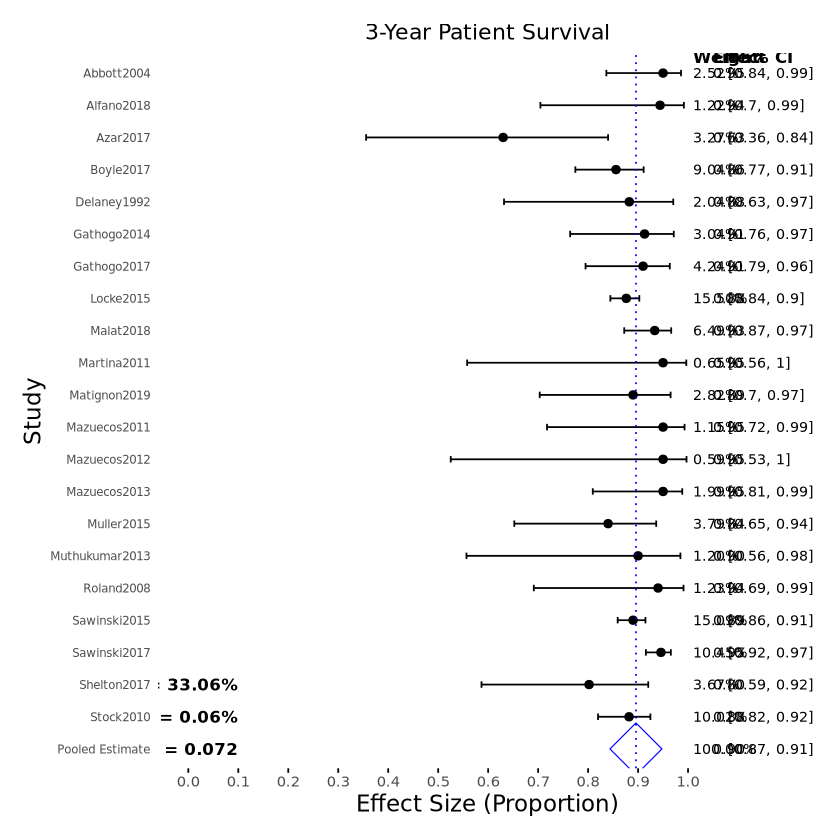

In [6]:

# Inspect the returned 'plot_data' for uniform CI bounds
results <- perform_meta_analysis_and_plot(
  pt_survival_df$'3_yr', 
  pt_survival_df$sample_size, 
  pt_survival_df$study_id, 
  "3-Year Patient Survival"
)
print(results$plot_data)

               study_id sample_size effect_size     ci_lb     ci_ub     weight
1          Ailioaie2017          24   0.9167000 0.7212236 0.9790844   4.863289
2            Alfano2018          19   0.7080000 0.4742143 0.8669914   7.606218
3            Alfano2020          22   0.6364000 0.4233816 0.8066601   8.572036
4           Delaney1992          17   0.4706000 0.2553830 0.6973339   7.888593
5           Gathogo2017          51   0.9100000 0.7948855 0.9634782   7.836597
6              Izzo2018          28   0.8210000 0.6357416 0.9233916   7.780522
7             Locke2015         499   0.8289000 0.7932896 0.8594625  14.241928
8           Martina2011          11   0.9500000 0.5579800 0.9965154   1.804465
9          Mazuecos2011          20   0.9500000 0.7177966 0.9930035   2.987068
10         Mazuecos2012          10   0.9500000 0.5251349 0.9969460   1.658547
11         Mazuecos2013          36   0.9167000 0.7713966 0.9728921   6.277992
12           Muller2015          27   0.7400000 0.54

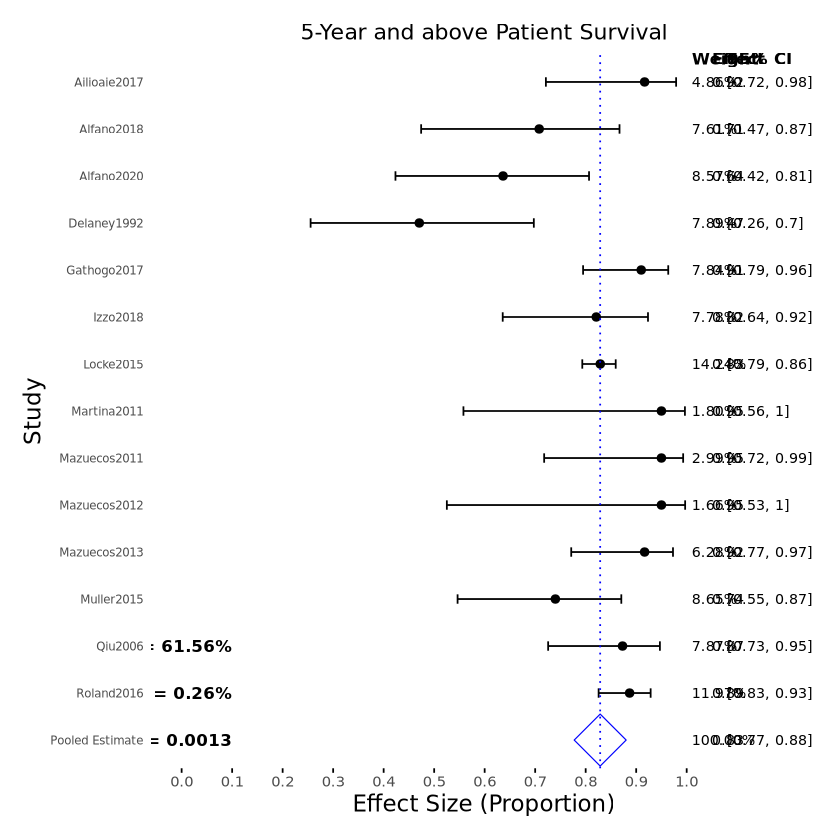

In [7]:

# Inspect the returned 'plot_data' for uniform CI bounds
results <- perform_meta_analysis_and_plot(
  pt_survival_df$'5_yr', 
  pt_survival_df$sample_size, 
  pt_survival_df$study_id, 
  "5-Year and above Patient Survival"
)
print(results$plot_data)

### 4. Meta-analysis for graft survival of kidney transplantation in people living with HIV

               study_id sample_size effect_size     ci_lb     ci_ub      weight
1            Alfano2018          19   0.8950000 0.6628639 0.9736515   1.0733006
2              Azar2017          13   0.9500000 0.6106983 0.9956734   0.3711867
3           Camargo2019          22   0.9100000 0.7012996 0.9775504   1.0830837
4          Camargo2019a          13   0.8500000 0.5528585 0.9629229   0.9963432
5           Delaney1992          17   0.9412000 0.6796906 0.9917861   0.5655404
6            Durand2021          75   0.9171000 0.8295995 0.9617412   3.4275826
7            Gasser2009          27   0.9500000 0.7709615 0.9907618   0.7709262
8           Gathogo2014          35   0.9130000 0.7641084 0.9714274   1.6711426
9           Gathogo2016          78   0.9500000 0.8728271 0.9813428   2.2271202
10          Gathogo2017          51   0.9300000 0.8192146 0.9749703   1.9957521
11            Locke2009         100   0.8790000 0.7993141 0.9298231   6.3933677
12            Locke2014         516   0.

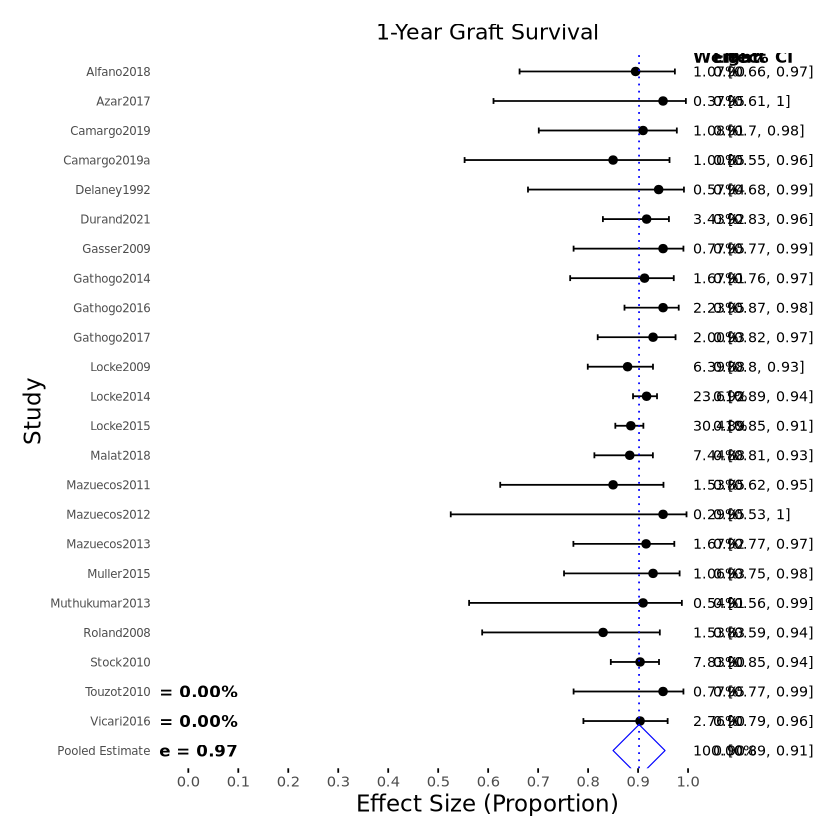

In [8]:
# Select and rename columns
gf_survival_df <- df[c('sample_size_(hiv_seropositive_only)', 'study_id', 
                       "1-year_graft_survival_(%)_hiv+",
                        "3-year_graft_survival_(%)_hiv+",
                        ">=_5-year_graft_survival_(%)_hiv+")]
names(gf_survival_df) <- c('sample_size', 'study_id', '1_yr', '3_yr', '5_yr')

results <- perform_meta_analysis_and_plot(
  gf_survival_df$'1_yr', 
  gf_survival_df$sample_size, 
  gf_survival_df$study_id, 
  "1-Year Graft Survival"
)
print(results$plot_data)

               study_id sample_size effect_size     ci_lb     ci_ub      weight
1            Abbott2004          47   0.9500000 0.8365371 0.9860220   3.0090017
2            Alfano2018          19   0.7710000 0.5359035 0.9075492   3.8779436
3              Azar2017          13   0.9500000 0.6106983 0.9956734   1.0933961
4             Boyle2017         104   0.5769000 0.4802731 0.6679814   7.7344539
5           Delaney1992          17   0.5176000 0.2929949 0.7353116   4.4091589
6           Gathogo2014          35   0.8470000 0.6880393 0.9328651   4.5601758
7           Gathogo2017          51   0.7800000 0.6463739 0.8730495   6.0058903
8             Locke2015         499   0.7770000 0.7383646 0.8113875   8.6609256
9             Malat2018         120   0.6167000 0.5268646 0.6992160   7.8595208
10         Matignon2019          26   0.8200000 0.6261756 0.9253147   4.1802077
11         Mazuecos2011          20   0.7440000 0.5156571 0.8880602   4.1634504
12         Mazuecos2012          10   0.

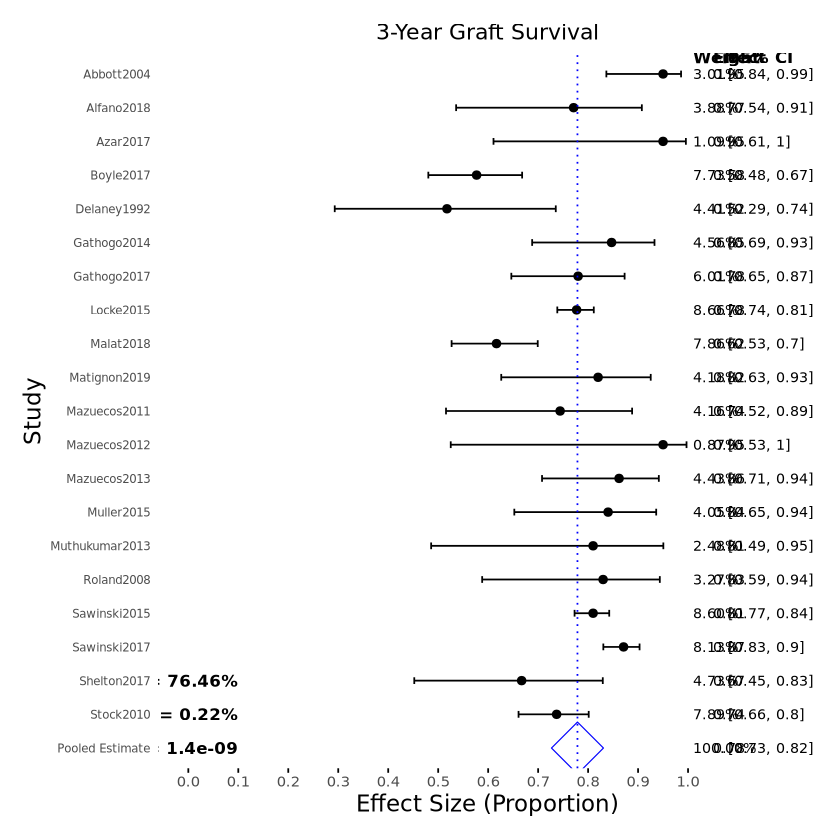

In [9]:
results <- perform_meta_analysis_and_plot(
  gf_survival_df$'3_yr', 
  gf_survival_df$sample_size, 
  gf_survival_df$study_id, 
  "3-Year Graft Survival"
)
print(results$plot_data)

               study_id sample_size effect_size     ci_lb     ci_ub     weight
1          Ailioaie2017          24    0.875000 0.6761631 0.9591298   4.418990
2            Alfano2018          19    0.578000 0.3552889 0.7729437   6.740050
3            Alfano2020          22    0.818200 0.6036619 0.9300627   5.242871
4           Delaney1992          17    0.258800 0.1054980 0.5082855   5.228946
5           Gathogo2017          51    0.780000 0.6463739 0.8730495   9.952883
6              Izzo2018          28    0.714000 0.5237883 0.8499944   7.747214
7             Locke2015         499    0.693500 0.6516329 0.7324018  19.603371
8          Mazuecos2011          20    0.744000 0.5156571 0.8880602   5.867912
9          Mazuecos2012          10    0.750000 0.4175734 0.9262161   3.353577
10           Muller2015          27    0.840000 0.6523406 0.9362619   5.663208
11              Qiu2006          38    0.651000 0.4891007 0.7842284   9.880402
12           Roland2016         150    0.693000 0.61

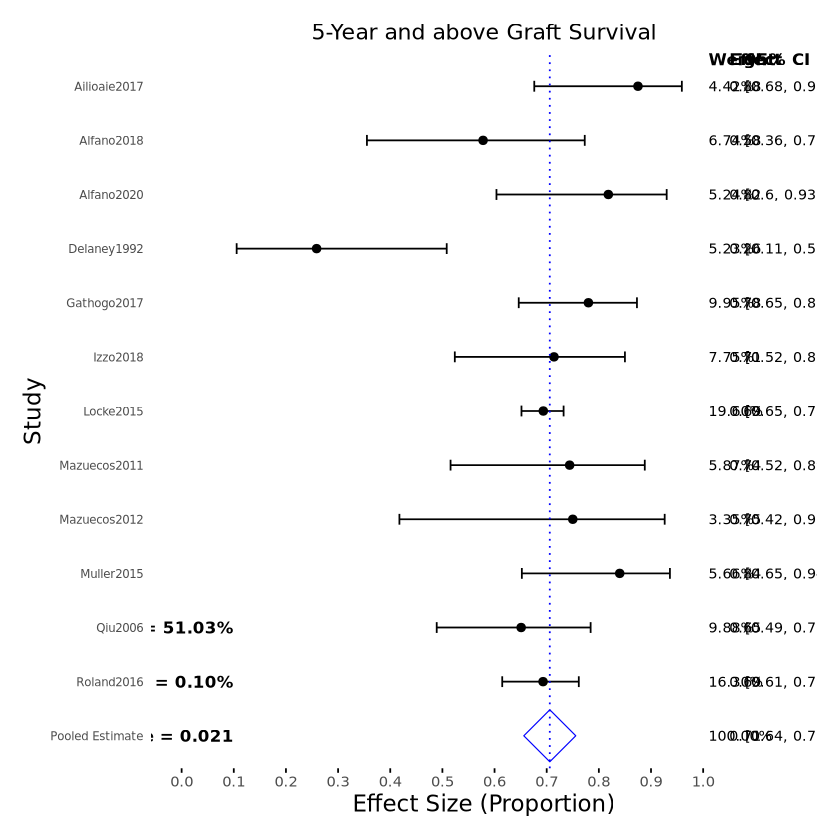

In [10]:
results <- perform_meta_analysis_and_plot(
  gf_survival_df$'5_yr', 
  gf_survival_df$sample_size, 
  gf_survival_df$study_id, 
  "5-Year and above Graft Survival"
)
print(results$plot_data)

### 5. Meta-analysis for rejection of kidney transplantation in people living with HIV

Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


               study_id sample_size effect_size       ci_lb     ci_ub
1            Alfano2018          19   0.3290000 0.158462620 0.5607703
2              Azar2017          13   0.1538000 0.038719462 0.4505914
3             Boyle2017         104   0.6635000 0.567630287 0.7475659
4          Camargo2019a          13   0.0769000 0.010713202 0.3905607
5           Delaney1992          17   0.0588000 0.008213918 0.3203094
6            Durand2021          75   0.3600000 0.259828869 0.4740558
7            Gasser2009          27   0.3333000 0.183401600 0.5266933
8           Gathogo2014          35   0.4700000 0.313473723 0.6326588
9           Gathogo2016          78   0.3590000 0.260701204 0.4707617
10          Gathogo2017          51   0.3600000 0.241012836 0.4991016
11            Locke2014         516   0.1500000 0.121720155 0.1834776
12            Lorio2016          36   0.1787000 0.084877005 0.3379362
13            Malat2018         120   0.5333000 0.443927450 0.6205851
14         Matignon2

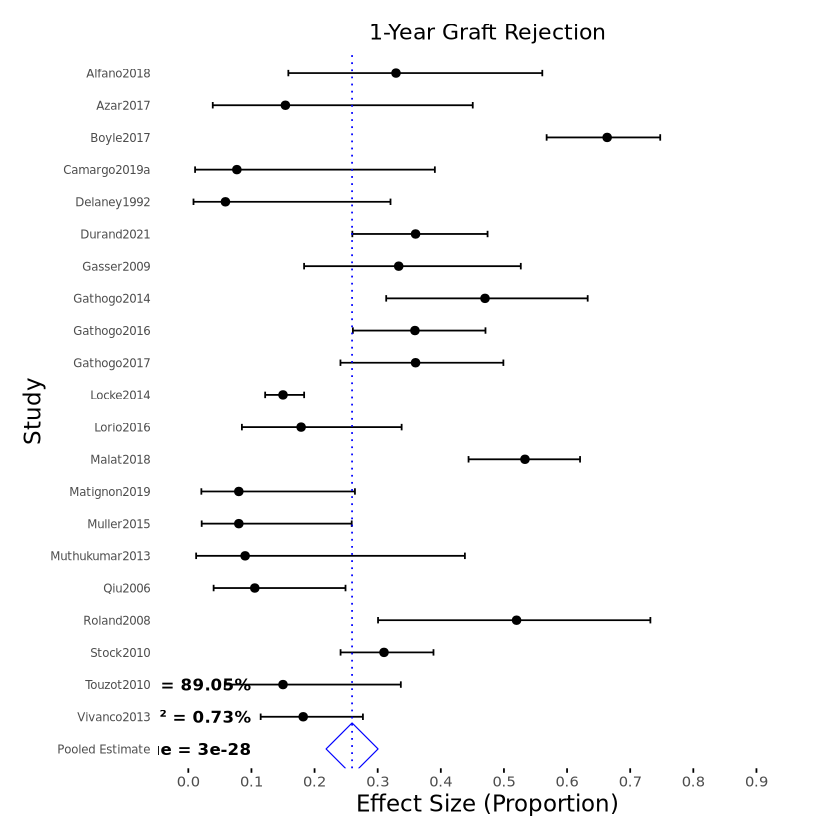

In [11]:
# Select and rename columns
rj_survival_df <- df[c('sample_size_(hiv_seropositive_only)', 'study_id', 
                      "1-year_cumulative_graft_rejection_(%)_hiv+",
                      "3-year_cumulative_graft_rejection_(%)_hiv+",
                      ">=_5-year_cumulative_graft_rejection_(%)_hiv+")]
names(rj_survival_df) <- c('sample_size', 'study_id', '1_yr', '3_yr', '5_yr')

results <- perform_meta_analysis_and_plot(
  rj_survival_df$'1_yr', 
  rj_survival_df$sample_size, 
  rj_survival_df$study_id, 
  "1-Year Graft Rejection"
)
print(results$plot_data)